In [ ]:
import zipfile
import os

zip_path = '/content/Birds_audio_dataset.zip'
extract_path = '/content/Birds_audio_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to: {extract_path}")


Extracted to: /content/Birds_audio_dataset


In [ ]:
# Constants
MAX_LEN = 40
SAMPLE_RATE = 22050
N_MFCC = 13

# Feature extraction function
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
        if mfcc.shape[0] < MAX_LEN:
            mfcc = np.pad(mfcc, ((0, MAX_LEN - mfcc.shape[0]), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:MAX_LEN]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
# Load data
import os # This import is likely already present at the top of the file. But if it's not add this import line
features = []
labels = []

# Define AUDIO_PATH, assuming extract_path from the previous cell is the correct path
AUDIO_PATH = '/content/Birds_audio_dataset'

for root, dirs, files in os.walk(AUDIO_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            label = os.path.basename(root)
            mfcc = extract_features(file_path)
            features.append(mfcc)
            labels.append(label)

X = np.array(features)
y = np.array(labels)

In [ ]:
# Label encoding
le = LabelEncoder()
y_encoded = tf.keras.utils.to_categorical(le.fit_transform(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Data loaded. Shape: {X.shape}, Classes: {le.classes_}")

# Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN, N_MFCC)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Data loaded. Shape: (85, 40, 13), Classes: ['crow' 'parrot' 'peacock' 'sparrow']
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.4240 - loss: 1.3121 - val_accuracy: 0.5294 - val_loss: 1.1379
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5233 - loss: 1.1105 - val_accuracy: 0.6471 - val_loss: 0.9875
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7691 - loss: 0.9067 - val_accuracy: 0.8235 - val_loss: 0.8416
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9220 - loss: 0.7044 - val_accuracy: 0.8235 - val_loss: 0.7298
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8946 - loss: 0.4856 - val_accuracy: 0.8235 - val_loss: 0.6384
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9639 - loss: 0.3051 - val_accuracy: 0.8824 - val_loss: 0.4693
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9578 - loss: 0.2343 - val_accuracy: 0.8824 - val_loss: 0.4854
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import os
import torch

class BirdAudioMFCCDataset(Dataset):
    def __init__(self, root_dir, n_mfcc=13):
        self.samples = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.n_mfcc = n_mfcc

        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith('.wav'):
                    self.samples.append(os.path.join(label_dir, file))
                    self.labels.append(self.class_to_idx[label])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path = self.samples[idx]
        label = self.labels[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.n_mfcc,
            melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 40}
        )
        mfcc = mfcc_transform(waveform).squeeze(0)  # Shape: [n_mfcc, time]
        return mfcc, label


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 2 * 19, 64)  # Adjust shape after flattening
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, n_mfcc, time]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


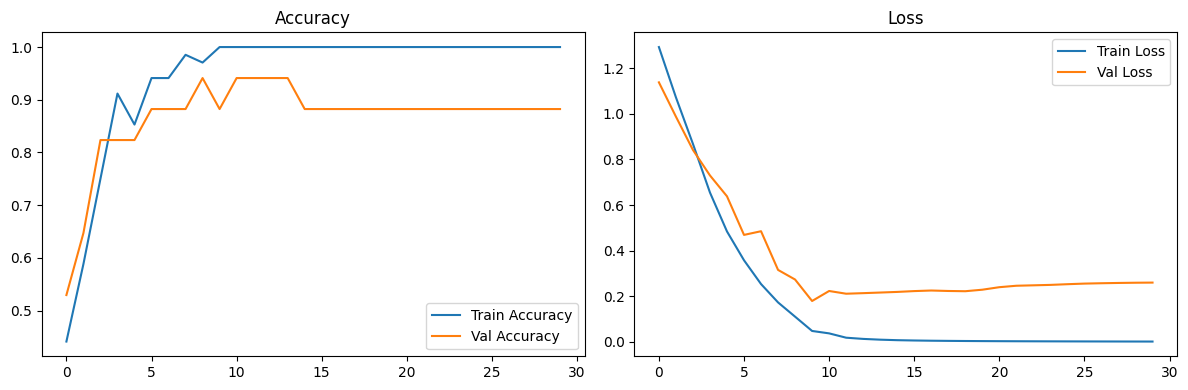

In [ ]:
# Accuracy and loss plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

In [ ]:
# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
              precision    recall  f1-score   support

        crow       0.86      1.00      0.92         6
      parrot       1.00      0.80      0.89         5
     peacock       0.67      0.67      0.67         3
     sparrow       1.00      1.00      1.00         3

    accuracy                           0.88        17
   macro avg       0.88      0.87      0.87        17
weighted avg       0.89      0.88      0.88        17



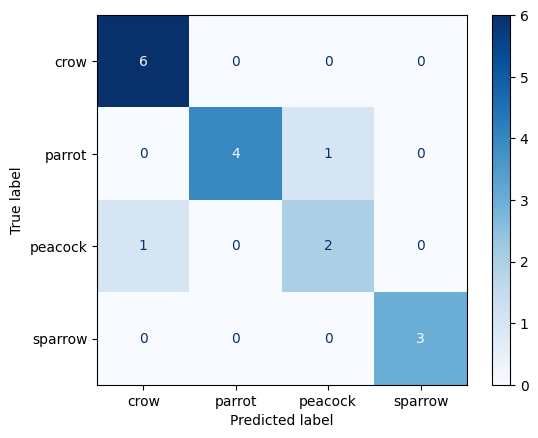

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
!pip install librosa resampy numpy
!pip install librosa resampy numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.7 MB/s eta 0:00:00


In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from google.colab import files
import os

In [ ]:
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050, duration=4.0)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        if mfccs.shape[1] < 40:
            pad_width = 40 - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :40]
        return mfccs.T
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [ ]:
# Step 5: Prediction function
def predict_gender(audio_file_path):
    mfccs = extract_features(audio_file_path)
    if mfccs is not None:
        mfccs = np.expand_dims(mfccs, axis=0)
        prediction = model.predict(mfccs)
        predicted_class = np.argmax(prediction)
        predicted_label = le.inverse_transform([predicted_class])[0]
        return predicted_label
    else:
        return "Error extracting features."

In [ ]:

import IPython.display as ipd
uploaded = files.upload()

for fn in uploaded.keys():
    audio_file_path = fn
    predicteds_sound = predict_gender(audio_file_path)
    print(f"Predicted Birds audio: {audio_file_path}: {predicteds_sound}")

    mfccs = extract_features(audio_file_path)

    if mfccs is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs.T, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCCs for {audio_file_path} (Predicted: {predicteds_sound})')
        plt.tight_layout()
        plt.show()

ipd.Audio(audio_file_path)


Using file: /content/Birds_audio_dataset/DATASET/Birds/parrot/parrot_1_part_15.wav


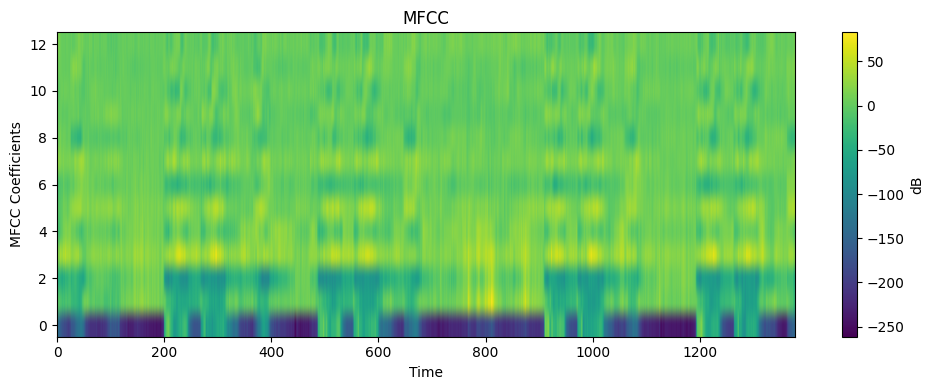

In [ ]:
import os
import torchaudio
import matplotlib.pyplot as plt
from torchaudio.transforms import MFCC

# Path to extracted dataset
dataset_path = '/content/Birds_audio_dataset'

# Pick the first .wav file found in the dataset
def find_first_wav_file(path):
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.wav'):
                return os.path.join(root, file)
    return None

audio_path = find_first_wav_file(dataset_path)
print(f"Using file: {audio_path}")

# Load audio
waveform, sample_rate = torchaudio.load(audio_path)

# Compute MFCC
mfcc_transform = MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 40})
mfcc = mfcc_transform(waveform)

# Plot MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfcc[0].numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()